Starting Flower client...
FlowerClient.__init__ called


	Instead, use the `flower-supernode` CLI command to start a SuperNode as shown below:

		$ flower-supernode --insecure --superlink='<IP>:<PORT>'

	To view all available options, run:

		$ flower-supernode --help

	Using `start_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      
INFO :      Received: train message 37b9d901-ab5d-4330-adaf-867c78da684b


FlowerClient.fit called
Images from: DatasetYildirim
Creating dataloaders...
Dataloaders created successfully.
2 1163 290
Salvando FL-DatasetYildirim-FL


epoch,train_loss,valid_loss,accuracy,time
0,0.865854,1.050229,0.572414,01:09
1,0.779763,2.003205,0.596552,01:03
2,0.784194,6.335171,0.393103,01:04
3,0.852088,1.478180,0.444828,01:03
4,0.825727,0.848536,0.524138,01:00
5,0.806814,0.808196,0.544828,00:59
6,0.783088,0.661668,0.634483,00:59
7,0.749576,0.822354,0.468966,00:59
8,0.723193,0.619114,0.662069,00:59
9,0.699841,0.596960,0.696552,01:00


FlowerClient.get_parameters called


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 1b15643c-2523-45ae-a188-1df1f875cc6f


FlowerClient.evaluate called
Images from: DatasetYildirim
Creating dataloaders...
Dataloaders created successfully.


              precision    recall  f1-score   support

Kidney_stone       0.54      0.49      0.52       165
      Normal       0.57      0.62      0.60       181

    accuracy                           0.56       346
   macro avg       0.56      0.56      0.56       346
weighted avg       0.56      0.56      0.56       346



INFO :      Sent reply
INFO :      
INFO :      Received: train message bfec18ee-b6c6-420a-8273-2233e6facb80


FlowerClient.fit called
Images from: DatasetYildirim
Creating dataloaders...
Dataloaders created successfully.
2 1163 290
Salvando FL-DatasetYildirim-FL


epoch,train_loss,valid_loss,accuracy,time
0,0.658994,3.083463,0.603448,01:03
1,0.690045,1.293014,0.437931,01:02
2,0.723976,3.818581,0.613793,01:06
3,0.678353,2.175366,0.396552,01:29
4,0.618629,20.921255,0.403448,01:01
5,0.522407,2.676781,0.427586,01:03
6,0.425224,0.353403,0.886207,01:04
7,0.364223,0.306049,0.896552,00:59
8,0.307076,0.130190,0.958621,00:59
9,0.261588,0.123394,0.958621,00:59


FlowerClient.get_parameters called


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 72b1e585-ba19-4983-b158-18d0ca3b6b31


FlowerClient.evaluate called
Images from: DatasetYildirim
Creating dataloaders...
Dataloaders created successfully.


              precision    recall  f1-score   support

Kidney_stone       0.93      0.90      0.91       165
      Normal       0.91      0.94      0.92       181

    accuracy                           0.92       346
   macro avg       0.92      0.92      0.92       346
weighted avg       0.92      0.92      0.92       346



INFO :      Sent reply
INFO :      
INFO :      Received: train message c82f9be8-9aca-4e73-8a89-77314fea8de3


FlowerClient.fit called
Images from: DatasetYildirim
Creating dataloaders...
Dataloaders created successfully.
2 1163 290
Salvando FL-DatasetYildirim-FL


epoch,train_loss,valid_loss,accuracy,time
0,0.161793,0.175304,0.941379,01:03
1,0.196831,0.624819,0.779310,01:03
2,0.275322,0.767016,0.703448,01:03
3,0.322622,10.546048,0.403448,01:02
4,0.305836,0.220326,0.944828,00:59
5,0.342280,0.511119,0.813793,00:59
6,0.311107,0.125455,0.955172,00:59
7,0.266974,0.107426,0.968966,00:59
8,0.225957,0.132925,0.951724,00:59
9,0.198245,0.128922,0.955172,00:59


FlowerClient.get_parameters called


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 3b421dc6-0557-4f14-9713-8f2e8e0777fa


FlowerClient.evaluate called
Images from: DatasetYildirim
Creating dataloaders...
Dataloaders created successfully.


              precision    recall  f1-score   support

Kidney_stone       0.92      0.93      0.92       165
      Normal       0.94      0.92      0.93       181

    accuracy                           0.93       346
   macro avg       0.93      0.93      0.93       346
weighted avg       0.93      0.93      0.93       346



INFO :      Sent reply
INFO :      
INFO :      Received: train message c315b207-6022-445b-bd62-bc42a8b80acb


FlowerClient.fit called
Images from: DatasetYildirim
Creating dataloaders...
Dataloaders created successfully.
2 1163 290
Salvando FL-DatasetYildirim-FL


epoch,train_loss,valid_loss,accuracy,time
0,0.134248,0.108921,0.965517,01:03
1,0.145999,0.420121,0.817241,01:03
2,0.199033,0.337547,0.858621,01:03
3,0.215350,0.219290,0.958621,01:02
4,0.215124,0.412922,0.865517,01:00
5,0.216505,0.104395,0.962069,00:59
6,0.180518,0.160569,0.955172,00:59
7,0.150438,0.100892,0.965517,00:59
8,0.126379,0.096353,0.968966,00:59
9,0.108762,0.102434,0.968966,00:59


FlowerClient.get_parameters called


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a8114729-20c2-409f-a866-825f22dfaebd


FlowerClient.evaluate called
Images from: DatasetYildirim
Creating dataloaders...
Dataloaders created successfully.


              precision    recall  f1-score   support

Kidney_stone       0.96      0.93      0.94       165
      Normal       0.94      0.97      0.95       181

    accuracy                           0.95       346
   macro avg       0.95      0.95      0.95       346
weighted avg       0.95      0.95      0.95       346



INFO :      Sent reply
INFO :      
INFO :      Received: train message fe78e120-5974-4ed0-881c-88cb8eb2c101


FlowerClient.fit called
Images from: DatasetYildirim
Creating dataloaders...
Dataloaders created successfully.
2 1163 290
Salvando FL-DatasetYildirim-FL


epoch,train_loss,valid_loss,accuracy,time
0,0.085029,0.129774,0.951724,01:04
1,0.101526,0.139081,0.955172,01:03
2,0.131408,0.163152,0.941379,01:03
3,0.167609,0.440538,0.841379,01:02
4,0.175593,1.891107,0.479310,00:59
5,0.165794,0.105557,0.968966,00:59
6,0.165533,0.091536,0.975862,00:59
7,0.145906,0.114238,0.955172,01:00
8,0.128326,0.111574,0.951724,01:03
9,0.116084,0.108016,0.958621,01:04


FlowerClient.get_parameters called


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 37ef8cbd-2810-4ecb-80c5-6e5394eb0594


FlowerClient.evaluate called
Images from: DatasetYildirim
Creating dataloaders...
Dataloaders created successfully.


              precision    recall  f1-score   support

Kidney_stone       0.92      0.98      0.95       165
      Normal       0.98      0.92      0.95       181

    accuracy                           0.95       346
   macro avg       0.95      0.95      0.95       346
weighted avg       0.95      0.95      0.95       346



INFO :      Sent reply
INFO :      
INFO :      Received: reconnect message 2beccc61-342f-443e-8234-40df882bcbb2
INFO :      Disconnect and shut down


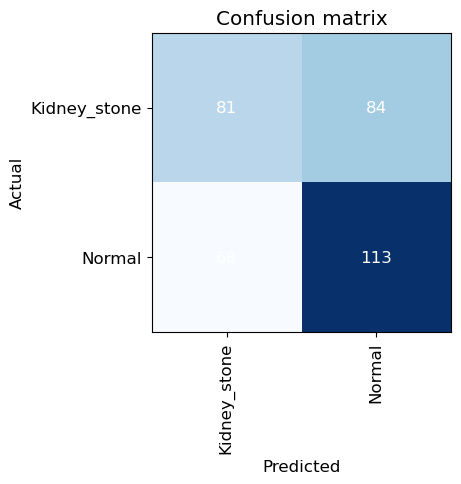

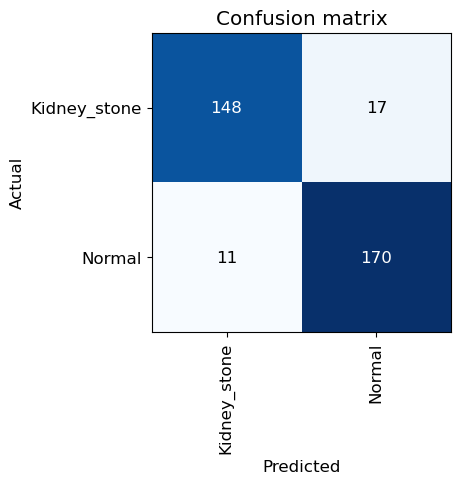

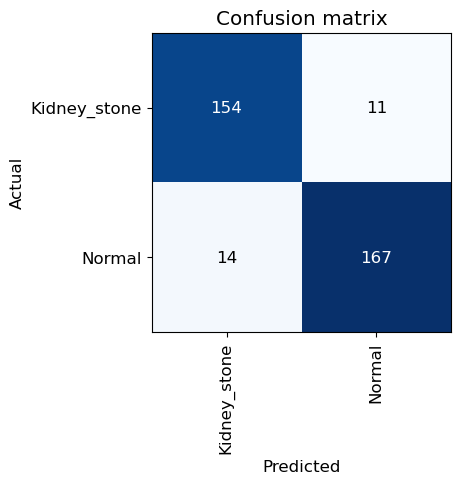

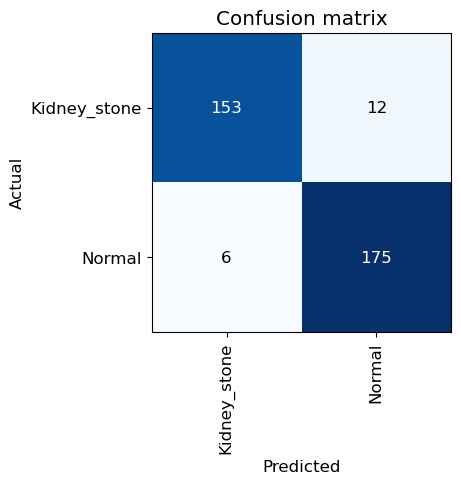

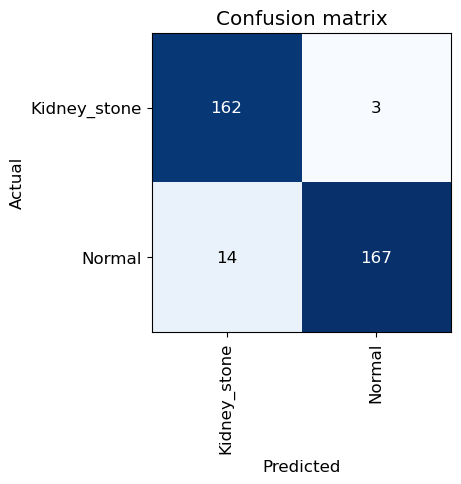

In [1]:
import sys
sys.stdout.flush()

import sys
import flwr as fl
from task import carregar_e_processar_dados, treinar_modelo_flower, avaliar_modelo_flower
import torch.nn as nn
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *
import json

class FlowerClient(fl.client.NumPyClient):
    def __init__(self):
        print("FlowerClient.__init__ called")
        self.model = nn.Sequential(create_body(xresnet50(), pretrained=False), create_head(nf=2048, n_out=2))

    def get_parameters(self, config):
        print("FlowerClient.get_parameters called")
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters):
        print("FlowerClient.set_parameters called")
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = dict((k, torch.tensor(v)) for k, v in params_dict)
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        print("FlowerClient.fit called")
        dls = carregar_e_processar_dados('DatasetYildirim', 'train')
        torch.cuda.empty_cache()
        learn = treinar_modelo_flower(self.model, dls, 0)
        self.model = learn.model
        return self.get_parameters({}), len(dls.train_ds), {}

    def evaluate(self, parameters, config):
        print("FlowerClient.evaluate called")
        dls = carregar_e_processar_dados('DatasetYildirim', 'test')
        torch.cuda.empty_cache()
        metricas = avaliar_modelo_flower(self.model, dls)
        return metricas[0], len(dls.valid_ds), {"accuracy": metricas[1], "loss": metricas[0], "predicted_labels": json.dumps(metricas[2]), "true_labels": json.dumps(metricas[3]), "preds": json.dumps(metricas[4])}

if __name__ == "__main__":
    print("Starting Flower client...")
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=FlowerClient().to_client(),
    )

